In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dotenv import load_dotenv
from sqlalchemy import create_engine
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

In [2]:
def query(parametro):
    query = f'''
        SELECT 
            {parametro} Periodo,
            count(DISTINCT(Boleta)) boletas, 
            count(DISTINCT(id_producto)) productos,
            count(DISTINCT(id_cliente)) clientes,
            sum(Cantidad) almuerzos,
            sum(Total) ventas_clp
        FROM 
            (
                SELECT
                    Dia_del_Año,
                    Numero_de_Mes,
                    Numero_de_Semana,
                    Año,
                    id_cliente,
                    Boleta,
                    id_producto,
                    Cantidad,
                    Total,
                    Fecha
                FROM ingresos
                WHERE 1=1
                    AND Año = 2023
                    AND Numero_de_Mes >= 3
                    AND Tipo LIKE "ALMUERZOS"
            ) as sub
        GROUP BY 1
    '''
    return query

def prueba_dickey_fuller(serie_temporal):
    print("Resultados de la prueba de Dickey-Fuller")
    # print(serie_temporal.head(5))
    dftest = adfuller(serie_temporal, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No Lags Used', 'N° observaciones'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

    if dftest[1] <= 0.05:
        print('Conclusión:')
        print('Rechazar H0 - Los datos son estacionarios')
    else:
        print('Conclusión:')
        print('No rechazar H0 - Los datos no son estacionarios')


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100        

def evaluacion_metrica(y_true, y_pred):
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [3]:
load_dotenv()

url = f"mysql+mysqlconnector://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}/{os.getenv('DB_NAME')}"
engine = create_engine(url=url)

df_diario = pd.read_sql(query('Fecha'), con=engine)
# df_semana = pd.read_sql(query('Numero_de_Semana'), con=engine)
# df_mes = pd.read_sql(query('Numero_de_Mes'), con=engine)

df_diario['Periodo'] = pd.to_datetime(df_diario['Periodo'])

In [4]:
print('Evaluación Diaria')
prueba_dickey_fuller(df_diario['almuerzos'])

Evaluación Diaria
Resultados de la prueba de Dickey-Fuller
Test Statistic           -4.601314
p-value                   0.000128
No Lags Used              6.000000
N° observaciones        291.000000
Critical Value (1%)      -3.453023
Critical Value (5%)      -2.871524
Critical Value (10%)     -2.572090
dtype: float64
Conclusión:
Rechazar H0 - Los datos son estacionarios


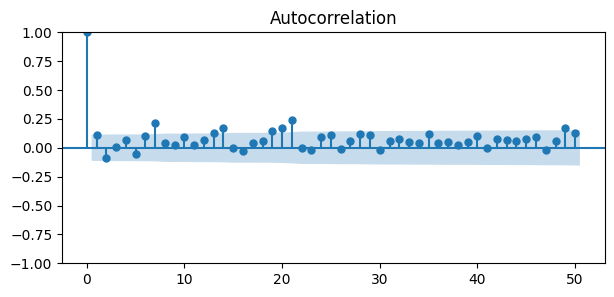

In [5]:
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(df_diario['almuerzos'], ax=ax, lags=50)
plt.show()

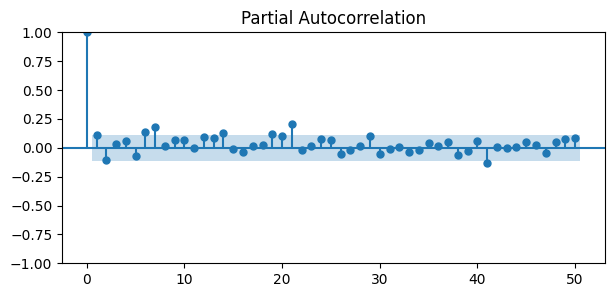

In [6]:
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(df_diario['almuerzos'], ax=ax, lags=50)
plt.show()

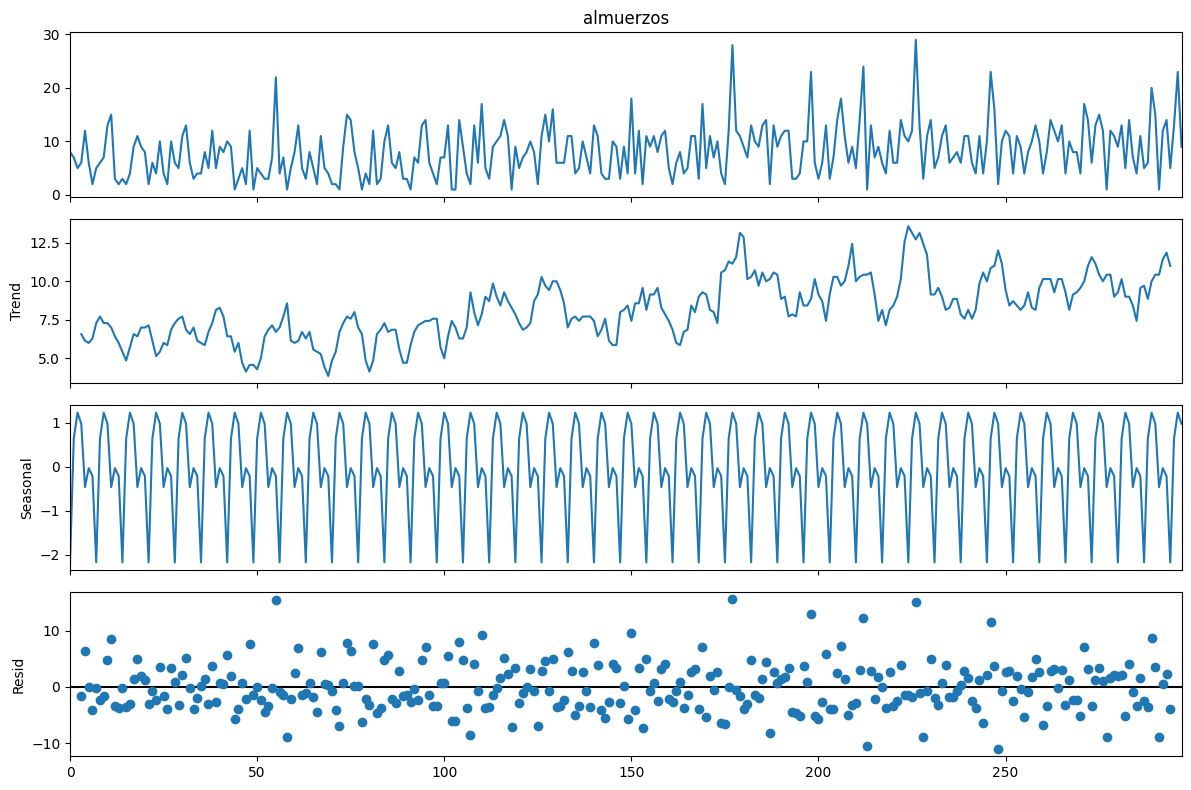

In [7]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_diario["almuerzos"], model = "add", period=7)
a.plot();

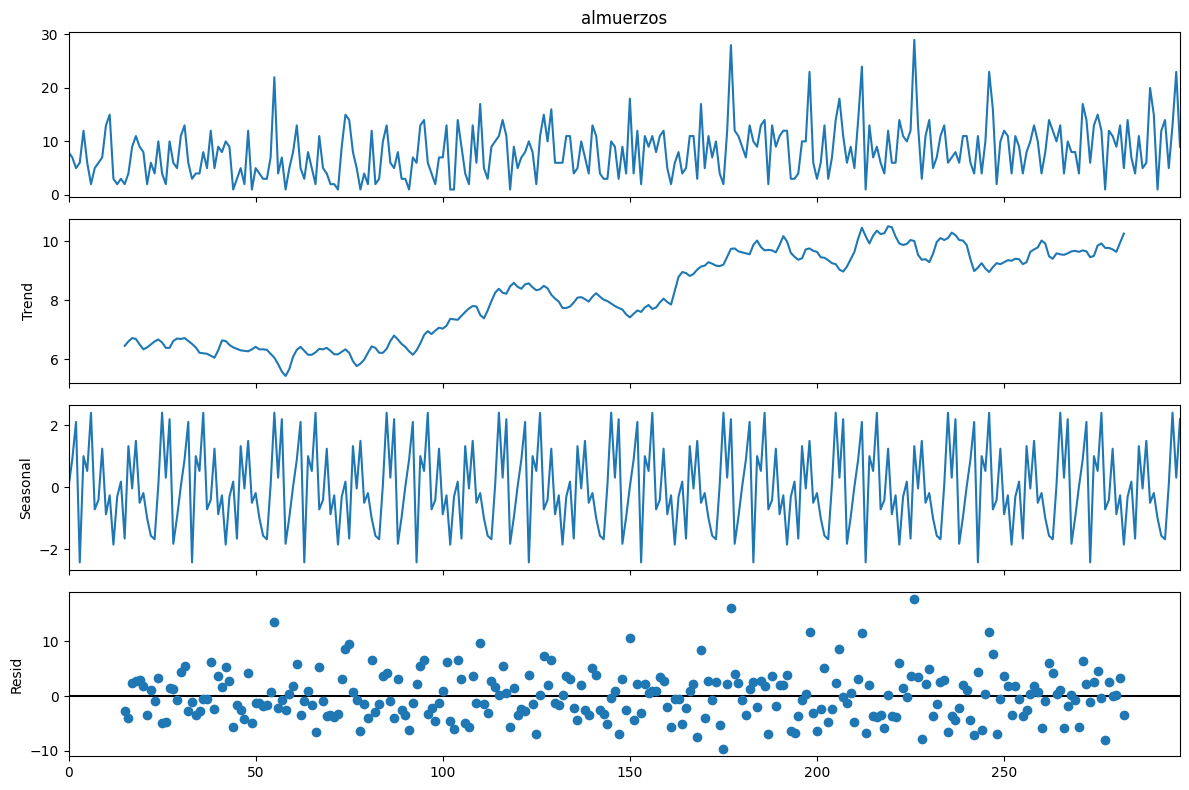

In [8]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_diario["almuerzos"], model = "add", period=30)
a.plot();

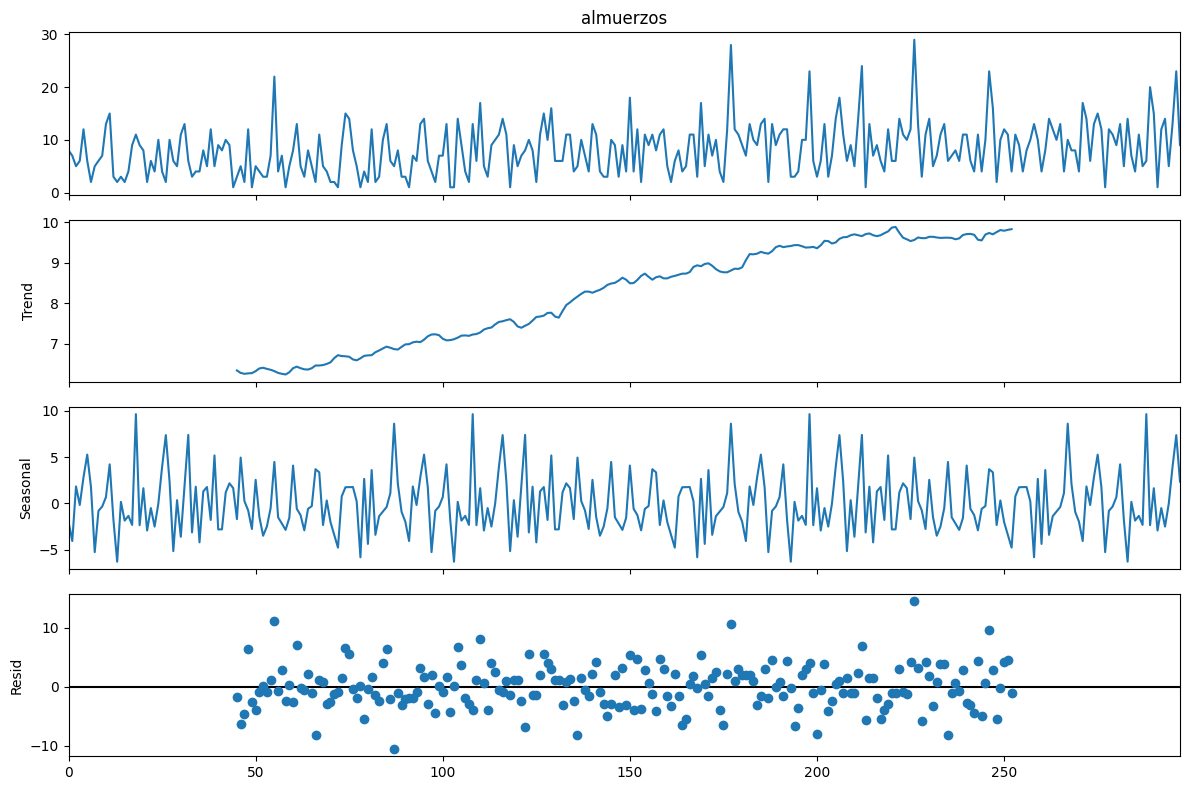

In [9]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_diario["almuerzos"], model = "add", period=90)
a.plot();

In [10]:
train_data = df_diario[(df_diario['Periodo']<'2023-12-01')]
test_data = df_diario[(df_diario['Periodo']>='2023-12-01')]

train_data.shape, test_data.shape

((267, 6), (31, 6))

In [28]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import statsmodels.api as sm

In [12]:
# Modelo Auto-Arima Semanal
modelo_auto_semanal = pm.auto_arima(train_data['almuerzos'], 
                       start_p=0, d=1, start_q=0, 
                       max_p=2, max_q=2,  # Reducido el rango de búsqueda
                       start_P=0, D=1, start_Q=0, 
                       max_P=1, max_D=1, max_Q=1,  # Reducido el rango de búsqueda
                       m=7, seasonal=True, 
                       error_action='warn', trace=False,  # Desactivada la traza
                       suppress_warnings=True, 
                       stepwise=True, random_state=20, 
                       n_fits=30)

print(modelo_auto_semanal)

 ARIMA(2,1,0)(0,1,1)[7]          


In [13]:
modelo_auto_semanal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  267
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 7)   Log Likelihood                -815.692
Date:                             Mon, 05 Feb 2024   AIC                           1639.384
Time:                                     15:10:08   BIC                           1653.611
Sample:                                          0   HQIC                          1645.104
                                             - 267                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5307      0.056     -9.543      0.000      -0.640      -0.422
ar.L2         -0.3106      0.061     -5.106      0.000      -0.430      -0.191
ma.S.L7       -0.8671      0.035    -24.631      0.000      -0.936      -0.798
sigma2        30.6211      2.369     12.927      0.000      25.978      35.264
===================================================================================
Ljung-Box (L1) (Q):                   2.96   Jarque-Bera (JB):                 9.45
Prob(Q):                              0.09   Prob(JB):                         0.01
Heteroskedasticity (H):               1.42   Skew:                             0.34
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
modelo_arima_semanal = sm.tsa.SARIMAX(train_data['almuerzos'], order=(2,1,0), seasonal_order=(0,1,1,7))
resultado_arima_semanal = modelo_arima_semanal.fit()
print(resultado_arima_semanal.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           almuerzos   No. Observations:                  267
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 7)   Log Likelihood                -815.692
Date:                             Mon, 05 Feb 2024   AIC                           1639.384
Time:                                     15:19:20   BIC                           1653.611
Sample:                                          0   HQIC                          1645.104
                                             - 267                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5307      0.056     -9.543      0.000      -0.640      -0.422
ar.L2         -0.3106      

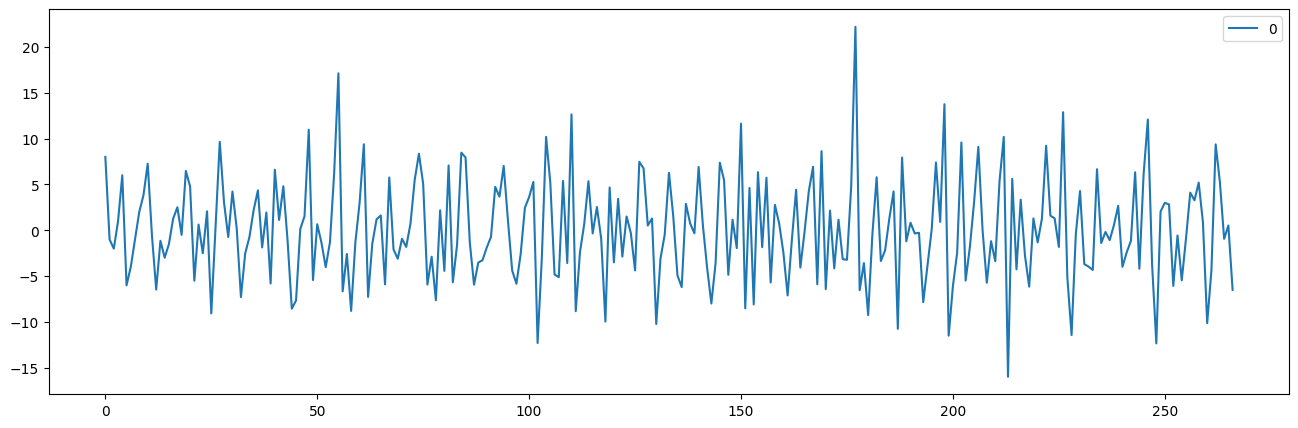

In [32]:
residuals = pd.DataFrame(resultado_arima_semanal.resid)
residuals.plot(figsize=(16,5))
plt.show();

In [18]:
pred_semanal = modelo_auto_semanal.predict(n_periods=298 - train_data.shape[0])
pred_semanal

267     9.966481
268    13.280749
269     7.806781
270     7.548390
271     8.997381
272     9.172344
273     6.233104
274     9.860671
275    12.533456
276     8.126511
277     7.501115
278     8.813409
279     9.174928
280     6.179146
281     9.778767
282    12.483948
283     8.068492
284     7.437550
285     8.755431
286     9.115708
287     6.118849
288     9.719427
289    12.424435
290     8.008773
291     7.377994
292     8.695853
293     9.056091
294     6.059260
295     9.659836
296    12.364836
297     7.949179
dtype: float64

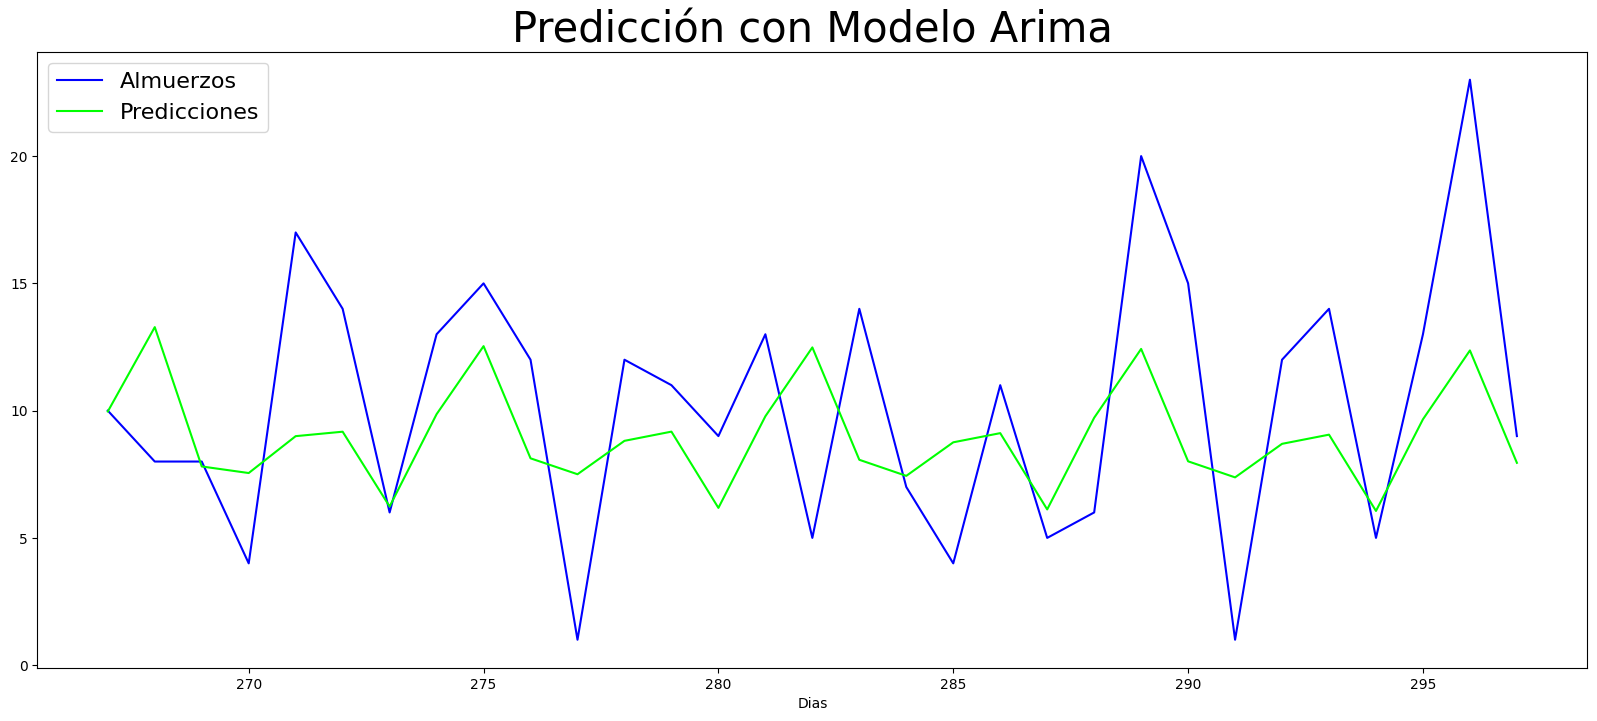

In [19]:
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test_data["almuerzos"],color="blue" ,label="Almuerzos")
plt.plot(pred_semanal, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Dias')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

In [20]:
evaluacion_metrica(test_data["almuerzos"], pred_semanal)

Evaluation metric results:-
MSE is : 21.753990806070952
MAE is : 3.863314204214088
RMSE is : 4.664117366241007
MAPE is : 76.5732820914744
R2 is : 0.1729731321847383



In [22]:
# Modelo Auto-Arima Mensual
modelo_auto_mensual = pm.auto_arima(train_data['almuerzos'], 
                       start_p=0, d=1, start_q=0, 
                       max_p=2, max_q=2,  # Reducido el rango de búsqueda
                       start_P=0, D=1, start_Q=0, 
                       max_P=1, max_D=1, max_Q=1,  # Reducido el rango de búsqueda
                       m=30, seasonal=True, 
                       error_action='warn', trace=False,  # Desactivada la traza
                       suppress_warnings=True, 
                       stepwise=True, random_state=20, 
                       n_fits=30)

print(modelo_auto_mensual)

 ARIMA(2,1,0)(1,1,0)[30]          


In [23]:
modelo_auto_mensual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  267
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 30)   Log Likelihood                -798.216
Date:                            Mon, 05 Feb 2024   AIC                           1604.432
Time:                                    15:14:15   BIC                           1618.287
Sample:                                         0   HQIC                          1610.017
                                            - 267                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4884      0.060     -8.103      0.000      -0.606      -0.370
ar.L2         -0.2905      0.064     -4.512      0.000      -0.417      -0.164
ar.S.L30      -0.5540      0.055     -9.998      0.000      -0.663      -0.445
sigma2        48.3597      4.646     10.408      0.000      39.253      57.466
===================================================================================
Ljung-Box (L1) (Q):                   2.00   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.16   Prob(JB):                         0.58
Heteroskedasticity (H):               1.45   Skew:                             0.16
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# modelo_arima_semanal = SARIMAX

In [24]:
pred_mensual = modelo_auto_mensual.predict(n_periods=298 - train_data.shape[0])
pred_mensual

267     5.611223
268     2.874416
269     4.849100
270     3.300431
271     6.288001
272    10.629645
273     1.091268
274     4.666693
275     3.970437
276    10.885243
277     6.110792
278    -1.248050
279     6.752765
280     4.322195
281     3.875157
282     5.185713
283     6.645659
284     5.199541
285     4.077776
286    15.280285
287     7.307629
288     3.105166
289     6.199562
290     5.185877
291     1.983417
292     5.767277
293     7.091489
294     7.307630
295     4.767277
296     1.307630
297     2.580214
dtype: float64

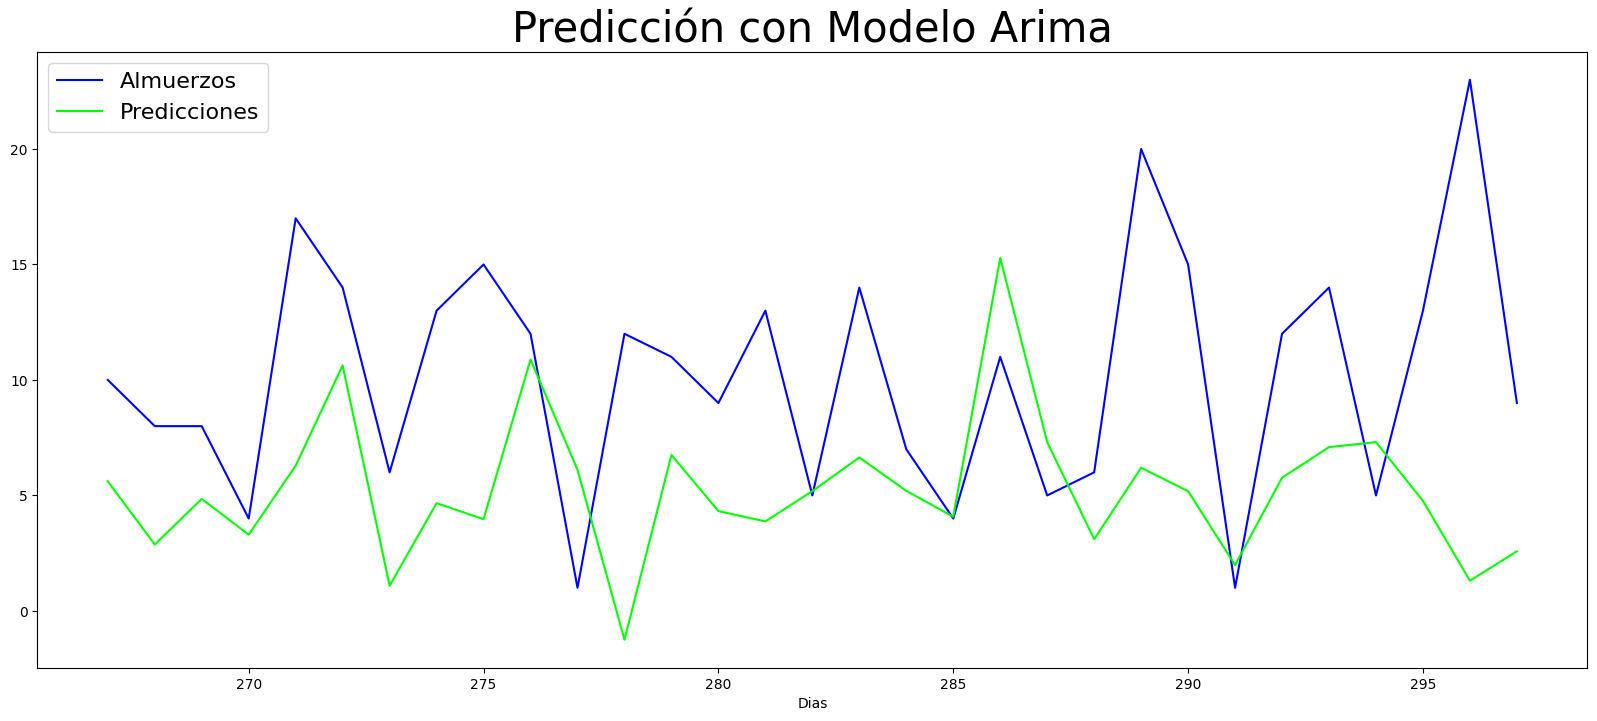

In [25]:
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test_data["almuerzos"],color="blue" ,label="Almuerzos")
plt.plot(pred_mensual, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Dias')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

In [26]:
evaluacion_metrica(test_data["almuerzos"], pred_mensual)

Evaluation metric results:-
MSE is : 57.15759964720395
MAE is : 5.952742733102908
RMSE is : 7.560264522303697
MAPE is : 67.3973234722109
R2 is : -1.1729746523048896



In [ ]:
# Modelo Auto-Arima Trimestral
modelo_auto_trimestral = pm.auto_arima(train_data['cantidad'], 
                       start_p=0, d=1, start_q=0, 
                       max_p=2, max_q=2,  # Reducido el rango de búsqueda
                       start_P=0, D=1, start_Q=0, 
                       max_P=1, max_D=1, max_Q=1,  # Reducido el rango de búsqueda
                       m=90, seasonal=True, 
                       error_action='warn', trace=False,  # Desactivada la traza
                       suppress_warnings=True, 
                       stepwise=True, random_state=20, 
                       n_fits=30)

print(modelo_auto_mensual)

In [ ]:
import statsmodels.api as sm

In [ ]:
# Implementación del Modelo -> SARIMAX(4, 1, 0)(2, 1, 0)
modelo_arima = sm.tsa.SARIMAX(train_data['almuerzos'], order = (4, 1, 0), seasonal_order= (2, 1, 0, 30)).fit()

In [ ]:
# Gráfico de línea de errores residuales
residuals = pd.DataFrame(modelo_arima.resid)
residuals.plot(figsize = (16, 5))
plt.show()

In [ ]:
# Diagrama de densidad del kernel de errores residuales
residuals.plot(kind='kde', figsize=(16,5))
plt.show()
print(residuals.describe())

In [ ]:
# Diagnostico de residuos ARIMA
modelo.plot_diagnostics(figsize = (20,8))
plt.show()

In [ ]:
arima_pred = modelo_arima.predict(start = len(train_data), end = len(df_diario)-1)
arima_pred

In [ ]:
plt.rcParams['figure.figsize'] = (20, 8)

plt.plot(test_data['almuerzos'], color='red', label='real')
plt.plot(arima_pred, color='black', label='Predicción')
plt.title("Predición vs Real Modelo ARIMA", fontsize=25)
plt.xlabel('Días')
plt.ylabel('Almuerzos')
plt.legend()
plt.show()